# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
!pip install nltk

In [2]:
# import libraries
import numpy as np
import pandas as pd
import os
from sqlalchemy import create_engine

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import *
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import *
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

print(os.listdir())

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['categories.csv', 'ML Pipeline Preparation-zh.ipynb', 'DisasterResponse.db', 'ETL Pipeline Preparation-zh.ipynb', '.ipynb_checkpoints', 'InsertDatabaseName.db', 'ETL Pipeline Preparation.ipynb', 'ML Pipeline Preparation.ipynb', '.Trash-0', 'Twitter-sentiment-self-drive-DFE.csv', 'messages.csv', 'P1Data.db']


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# load data from database
engine = create_engine('sqlite:///P1Data.db')
df = pd.read_sql_table('P1Data', engine)
X = 'message'
Y = [col for col in df.columns.tolist() if col not in ['id', 'message', 'original', 'genre']]

In [5]:
print("X: ", X)
print("T: ", Y)

X:  message
T:  ['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


In [6]:
# Survey target variables:

for col in Y:
    if df[col].nunique() != 2:
        print(col, ' : ', df[col].nunique())

related  :  3
child_alone  :  1


In [7]:
# Process the target variable:
df.drop(['child_alone'], axis=1, inplace=True)

index = df[df['related']==2].index
print(len(index))
df.drop(index, inplace=True)

Y.remove('child_alone')

188


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbbd20a5590>,
      dtype=object)

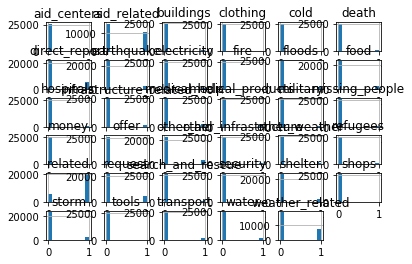

In [8]:
df[Y].hist()

### 2. Write a tokenization function to process your text data

In [9]:
def tokenize(text):
    import re
    
    processed_text = re.sub(r"[^A-Za-z0-9]", " ", text.lower()) # remove special characters.
    tokens = nltk.tokenize.word_tokenize(processed_text) # into word tokens
    
    stemmer = nltk.stem.PorterStemmer()
    stemmed_words = [stemmer.stem(_word) for _word in tokens if _word not in nltk.corpus.stopwords.words("english")]
    
    return stemmed_words

In [10]:
# Unit test:
tokenize(df.iloc[0]['message'])

['weather', 'updat', 'cold', 'front', 'cuba', 'could', 'pass', 'haiti']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [11]:
df.sample(3)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
16440,19348,The only people in sight are passing through f...,None,news,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2733,3153,Please don't forget about us. We are located i...,Mezanmi pinga nou bliye nou anko nou adrese no...,direct,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
25228,29139,* Germany: Team of 20 specialist alongwith the...,None,news,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
pipeline = Pipeline([
    ("tfidf_vectorizer", TfidfVectorizer(tokenizer=tokenize)) , 
    ("clf", MultiOutputClassifier(RidgeClassifier(random_state=2020)))
])



### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [13]:
from sklearn.model_selection import train_test_split

X, y = df[X], df[Y]
tra_x, val_x, tra_y, val_y = train_test_split(X, y, random_state=2020, test_size=0.3)

pipeline.fit(tra_x, tra_y)

Pipeline(memory=None,
         steps=[('tfidf_vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x7fbbd3909950>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 MultiOutputClassifier(estimator=RidgeClassifier(alpha=1.0,
                           

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [14]:
val_y.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
6849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17771,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8510,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19788,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21557,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
preds = pipeline.predict(val_x)
preds

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [16]:
from collections import deque

def eval_model(pipeline, val_x, val_y):
    
    accuracy, precision, recall, f1, index = deque(), deque(), deque(), deque(), deque() # placeholder for metrics
    
    preds = pipeline.predict(val_x)
    
    for i, col in enumerate(val_y.columns.tolist()):
        accuracy.append(accuracy_score(val_y[col], preds[:, i]))
        precision.append(precision_score(val_y[col], preds[:, i]))
        recall.append(recall_score(val_y[col], preds[:, i]))
        f1.append(f1_score(val_y[col], preds[:, i]))
        index.append(col)
        
    return pd.DataFrame({
        'accuracy' : accuracy ,
        'precision' : precision , 
        'recall' : recall , 
        'f1' : f1} , 
        index = index
    )

In [17]:
eval_metrics = eval_model(pipeline, val_x, val_y)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
eval_metrics

,accuracy,precision,recall,f1
related,0.820976,0.847703,0.932830,0.888232
request,0.900115,0.790672,0.553951,0.651475
offer,0.994365,0.000000,0.000000,0.000000
aid_related,0.768344,0.734932,0.685404,0.709304
medical_help,0.930721,0.647059,0.283414,0.394177
medical_products,0.955308,0.733766,0.268409,0.393043
search_and_rescue,0.973620,0.727273,0.141593,0.237037
security,0.980407,1.000000,0.006494,0.012903
military,0.969010,0.703704,0.265734,0.385787
water,0.960430,0.771739,0.557957,0.647662


In [19]:
print("Overall performance:\n{}".format(eval_metrics.mean()))

Overall performance:
accuracy     0.948470
precision    0.597253
recall       0.295337
f1           0.366034
dtype: float64


### 6. Improve your model
Use grid search to find better parameters. 

In [20]:
parameters = {
    'clf__estimator__alpha' : [0.001, 0.003, 0.01, 0.03, 0.1]
}


def f1_scorer(truth, prediction):
    assert truth.shape[1] == prediction.shape[1]
    
    f1_scores = [] 
    for i in range(truth.shape[1]):
        f1_scores.append(f1_score(truth[:, i], prediction[:, i]))
    
    return np.mean(f1_scores)

scorer = make_scorer(f1_scorer)

# Will use f1 as the target metric for CV. Due to the sparsity, accuracy is not a desirable metric
# for this task, and f1 score can balance the precision and recall.
cv = GridSearchCV(pipeline, param_grid=parameters, scoring=scorer, verbose=1, n_jobs=-1)

In [21]:
# Will use the whole dataset for Grid search CV.
cv_result = cv.fit(X.values, y.values)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  9.5min finished


In [25]:
cv_result.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf_vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x7fbbd3909950>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 MultiOutputClassifier(estimator=RidgeClassifier(alpha=0.1,
                           

In [24]:
cv_result.best_params_

{'clf__estimator__alpha': 0.1}

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [26]:
eval_metrics_using_best_params = eval_model(cv_result.best_estimator_, val_x, val_y)
eval_metrics

,accuracy,precision,recall,f1
related,0.820976,0.847703,0.932830,0.888232
request,0.900115,0.790672,0.553951,0.651475
offer,0.994365,0.000000,0.000000,0.000000
aid_related,0.768344,0.734932,0.685404,0.709304
medical_help,0.930721,0.647059,0.283414,0.394177
medical_products,0.955308,0.733766,0.268409,0.393043
search_and_rescue,0.973620,0.727273,0.141593,0.237037
security,0.980407,1.000000,0.006494,0.012903
military,0.969010,0.703704,0.265734,0.385787
water,0.960430,0.771739,0.557957,0.647662


In [28]:
print("Overall performance:\n{}".format(eval_metrics_using_best_params.mean()))

Overall performance:
accuracy     0.985680
precision    0.970405
recall       0.791239
f1           0.866409
dtype: float64


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [29]:
print("After the hyper-parameter tuning, the existing model performs pretty decent. It takes too much time for this grid search operation.")

After the hyper-parameter tuning, the existing model performs pretty decent. It takes too much time for this grid search operation.


### 9. Export your model as a pickle file

In [34]:
from sklearn.externals import joblib

joblib.dump(cv_result.best_estimator_, 'best_pipeline.pkl')

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['best_pipeline.pkl']

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.